In [1]:
 '''
Author information:
Joey R. Muffoletto
University of Texas at Austin
Autonomous Systems Group
jrmuff@utexas.edu
'''

'\nAuthor information:\nJoey R. Muffoletto\nUniversity of Texas at Austin\nAutonomous Systems Group\njrmuff@utexas.edu\n'

In [2]:
# import dill
# dill.load_session('realtime_notebook_PURDUE_data_vhub_32_with_queue.db')

In [3]:
import os

import realtime_manager as rm 
import graph_manager as gm
import reworked_graph as rg
import pandas as pd
import numpy as np
import copy
import sys

# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
'''
manager configurations

traffic test globals
'''

USE_PURDUE_DATA = True

MAX_ALLOWED_REQUESTS = 5

MIN_TOWERS = 2
NUM_VERTIHUBS = 16
MINUTES_OF_DATA = 1
ADDITIONAL_VERTIHUBS = 0 # used for file path purposes. leave num_vertihubs as the total number of vertihubs (including the additional)

TAU_MAX = 8
TAU = 0

FREQUENCY_MULTIPLIERS = [2]
FREQUENCY_MULTIPLIER = 1

LOW_TRAFFIC_MULTIPLIER = 1
HIGH_TRAFFIC_MULTIPLIER = 3

MIN_LOW_TRAFFIC = 0
MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * FREQUENCY_MULTIPLIER)

MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * FREQUENCY_MULTIPLIER)

MIN_TTL = 3
MAX_TTL = 7

FLIGHT_SPEED = 60 # m/s



DEFAULT_EMPTY_STATE = rg.State((),(),{"0" : 6})
rm.configure_realtime(tau=TAU, override_default_empty_state=DEFAULT_EMPTY_STATE)

# HIGH_TRAFFIC_FREQUENCY = .1 # use rand.random() = [0.0, 1.0], or, just add this value until = 1 then reset
HIGH_TRAFFIC_TRIGGER = 8
NUM_TIME_STEPS = 20



In [5]:
TRIPS_PATH = ""
VERTIPORTS_PATH = ""
if USE_PURDUE_DATA:
    TRIPS_PATH = 'data/Realtime/OpsLimits/trips_' + str(NUM_VERTIHUBS) + '_minutes-' + str(MINUTES_OF_DATA)
    if ADDITIONAL_VERTIHUBS > 0:
        TRIPS_PATH += '_additional_vhubs_' + str(ADDITIONAL_VERTIHUBS)
    TRIPS_PATH += '.csv'

    VERTIPORTS_PATH = 'data/Realtime/OpsLimits/vertiports_' + str(NUM_VERTIHUBS)
    if ADDITIONAL_VERTIHUBS > 0:
        VERTIPORTS_PATH += '_additional_vhubs_' + str(ADDITIONAL_VERTIHUBS)
    VERTIPORTS_PATH += '.csv'


In [6]:
'''
Input generation functions

low traffic is some random number between min_low_traffic and max_low_traffic, high traffic is the same with high

choose a random tower index everytime we add one

high traffic occurs everytime HIGH_TRAFFIC_FREQUENCY * TIME_STEPS is a whole number

TTL is a random number between MIN_TTL and MAX_TTL

Output format is a dictionary which maps tower index to a list of requests (tuples of preferred port and TTL )

This ouput is created per time step, so then the overall input is a list of these dictionaries, with each list index corresponding to the step of the simulation.

'''
import random
random.seed(10)
def generate_traffic(min_traffic, max_traffic):
    additional_requests_dict = dict()
#     counter = 0
    requests_to_add = random.randint(min_traffic, max_traffic)
    for i in range(requests_to_add):
#         if counter == NUM_VERTIHUBS:
#             counter = 0
#         tower_to_add_to = counter
#         counter+=1
        tower_to_add_to = random.randint(0, NUM_VERTIHUBS-1) # NUM_VERTIHUBS is OOB
        request_to_add = ('no_pref', random.randint(MIN_TTL, MAX_TTL))
#         request_to_add = ('no_pref', 5)
        if tower_to_add_to in additional_requests_dict:
            additional_requests_dict[tower_to_add_to].append(request_to_add)
        else:
            additional_requests_dict[tower_to_add_to] = [request_to_add]
    return additional_requests_dict
            
def generate_low_traffic():
    return generate_traffic(MIN_LOW_TRAFFIC, MAX_LOW_TRAFFIC)
    
def generate_high_traffic():
    return generate_traffic(MIN_HIGH_TRAFFIC, MAX_HIGH_TRAFFIC)

In [7]:
'''
Input Generation
'''
def generate_inputs():
    input = []
    high_traffic_counter = 1
    for time in range(NUM_TIME_STEPS):
        if high_traffic_counter == HIGH_TRAFFIC_TRIGGER:
            high_traffic_counter = 1
            input.append([generate_high_traffic()])
        else:
            high_traffic_counter += 1
            input.append([generate_low_traffic()])

    initial_system = [copy.deepcopy(gm.return_tower(0, 1, [],[6])) for i in range(NUM_VERTIHUBS)]
    return initial_system, input

In [8]:
'''
Input statistics:
'''
def generate_input_statistics(input):
    requests_per_tower = [0 for i in range(NUM_VERTIHUBS)]
    for time_step in range(len(input)):
        for i in range(NUM_VERTIHUBS):
            if i in input[time_step][0]:
                requests_per_tower[i]+=len(input[time_step][0][i])
    for i in range(NUM_VERTIHUBS):
        print("tower " + str(i) + "has " + str(requests_per_tower[i]) + " requests")
    average_input_frequency = sum([i for i in requests_per_tower])/(float(NUM_TIME_STEPS) * float(NUM_VERTIHUBS))
    print("average_input_frequency = " + str(average_input_frequency))
    return average_input_frequency

In [9]:
#purdue data methods
if USE_PURDUE_DATA == True:
    import random
    class Purdue_Data_Output:
        def __init__(self):
            self.num_denied_requests = 0
            self.additional_requests_culled = 0
            self.max_requests = 0
            self.num_expired_requests = 0
            self.expired_requests = [] # tracks the ttl and vertihub id of each expired request when it was popped off of the queue
            self.average_queue_size = [0 for i in range(NUM_VERTIHUBS)]
            
    from math import cos, asin, sqrt, pi

    def ll_distance(lat1, lon1, lat2, lon2):
        p = pi/180
        a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
        return 12742 * asin(sqrt(a)) #2*R*asin...   
        
    # make a list of lists of dictionaries which map tower indicies to requests
    def vertiport_statistics(vertiports_data, _file=sys.stdout):
        '''
        vertiport statistics
        this data is bogus as of 2/18 -> this is because we are not accounting for how the vertiports now can be mapped to multiple vertihubs if we are using additional vhubs
        '''
        vertiports_per_vertihub = [0 for i in range(NUM_VERTIHUBS)]
        for index, vertiport in vertiports_data.iterrows():
#             print((int(vertiport['vertihub'])))
            vertiports_per_vertihub[int(vertiport['vertihub_0'])] += 1
        assert(sum(vertiports_per_vertihub) == vertiports_data.shape[0])
        vertiports_per_vertihub
    
    def trip_statistics(trip_data, vertiports_data, _file=sys.stdout):
        '''
        trip statistics
        '''
        arrivals_per_vertihub = [[] for i in range(NUM_VERTIHUBS)]
        flight_popularity = dict()
        # get the trip arrival time per vertihub
        for index, trip in trip_data.iterrows():
            #calculate time of arrival (begin at trip.time), calculated between vertiports
            origin_port = vertiports_data.iloc[trip['OriginVertiport']]
            destination_port = vertiports_data.iloc[trip['DestinationVertiport']]
            if((origin_port['vertiport'],destination_port['vertiport']) not in flight_popularity.keys()):
                flight_popularity[(origin_port['vertiport'], destination_port['vertiport'])] = 1
            else:
                flight_popularity[(origin_port['vertiport'], destination_port['vertiport'])] += 1
            #trip distance in kilometers
            dist = ll_distance(origin_port['lat'], origin_port['long'], destination_port['lat'], destination_port['long'])
            travel_time = (dist*1000)/FLIGHT_SPEED # (km * 1000)/(m/s) -> seconds
            arrival_time = trip['Time'] + travel_time #takeoff time + travel_time = arrival time
            #add arrival time to vertihub
            arrivals_per_vertihub[trip['DestinationVertihub']].append(arrival_time)
        
        # for each list of vertihub, calculate the minimum, average, and maximum distance between arrivals
        differences_per_vertihub = []
        # simulated_arrivals
        for arrivals_list in arrivals_per_vertihub:
            sorted_arrivals = sorted(arrivals_list)
            if(len(sorted_arrivals) <= 1):
                continue
            differences = []
            for index in range(len(sorted_arrivals)-1):
                differences.append(sorted_arrivals[index+1] - sorted_arrivals[index])
            # print(sorted_arrivals)
            differences_per_vertihub.append(sorted(differences))
        
        for index, differences in enumerate(differences_per_vertihub):
            print('vertihub ' + str(index) + ' has minimum arrival difference of ' + str(differences[0]), file=_file)
            print('vertihub ' + str(index) + ' has average arrival difference of ' + str(sum(differences)/len(differences)), file=_file)
            print('vertihub ' + str(index) + ' has maximum arrival difference of ' + str(differences[len(differences)-1]), file=_file)
            print('vertihub ' + str(index) + ' has ' + str(len(differences)) + ' trips', file=_file)
            print('', file=_file)
           
        
        formatted_flight_popularity = [(flight_popularity[key], key) for key in flight_popularity.keys()]
        print('Most popular flight path ' + str((sorted(formatted_flight_popularity))[len(formatted_flight_popularity)-1]), file=_file)
        print('Total flight paths ' + str(len(formatted_flight_popularity)), file=_file)
        avg = sum([num for num, thing in formatted_flight_popularity])/len(formatted_flight_popularity)
        print('Mean requests per flight path ' + str(avg), file=_file)

        formatted_vertihub_popularity = [(len(differences_per_vertihub[i]), i) for i in range(len(differences_per_vertihub))]

        print('Sorted vertihub popularity: ' + str(sorted(formatted_vertihub_popularity, reverse=True)), file=_file)
    
    def load_vertiport_data(display_stats=True, _file=sys.stdout):
        
        vertiports_data = pd.read_csv(VERTIPORTS_PATH)

        if display_stats:
            vertiport_statistics(vertiports_data, _file)

        return vertiports_data
    def load_trip_data(vertiports_data, display_stats=True, _file=sys.stdout):

        trip_data = pd.read_csv(TRIPS_PATH)
        # Changed (3/8/22) to allow for trips where origin == destination
#         trip_data.drop(trip_data[trip_data.OriginVertihub == trip_data.DestinationVertihub].index, inplace=True) #drop trips where the origin and destination are the same vertiport, reduced from 4801 trips to 1692 with 10 vertiports
        if display_stats:
            trip_statistics(trip_data, vertiports_data, _file)
        return trip_data
    
    def format_purdue_dataset():
        vertiports_data = load_vertiport_data()
        trip_data = load_trip_data(vertiports_data)
        arrivals_per_vertihub = [[] for i in range(NUM_VERTIHUBS)]
        # get the trip arrival time per vertihub
        latest_arrival_time = -1
        for index, trip in trip_data.iterrows():
            #calculate time of arrival (begin at trip.time), calculated between vertiports
            origin_port = vertiports_data.iloc[trip['OriginVertiport']]
            destination_port = vertiports_data.iloc[trip['DestinationVertiport']]
            #trip distance in kilometers
            dist = ll_distance(origin_port['lat'], origin_port['long'], destination_port['lat'], destination_port['long'])
            travel_time = (dist*1000)/FLIGHT_SPEED # (km * 1000)/(m/s) -> seconds
            arrival_time = trip['Time'] + travel_time #takeoff time + travel_time = arrival time
            if(arrival_time > latest_arrival_time):
                latest_arrival_time = arrival_time
            #add arrival time to vertihub
            # arrivals_per_vertihub[trip['DestinationVertihub']].append((
            #     int(arrival_time), 
            #     int(destination_port['vertihub']), 
            #     int(destination_port['vertiport']
            # )))
            arrivals_per_vertihub[trip['DestinationVertihub']].append((
                int(arrival_time), 
                int(trip['DestinationVertihub']), 
                int(destination_port['vertiport']
            )))
        #build input list
        input = [[dict()] for i in range(int(latest_arrival_time)+1)]
        for arrivals in arrivals_per_vertihub:
            for arrival in arrivals:
                arrival_time, destination_hub, destination_port = arrival
                randomized_TTL = random.randint(MIN_TTL, MAX_TTL)
                to_add = (('' + str(destination_port)), randomized_TTL) # (destination port, time to land)
                if destination_hub not in input[arrival_time][0].keys():
                    input[arrival_time][0][destination_hub] = []
                #TODO: CHANGE THIS EVENTUALLY!!!!!
                if(len(input[arrival_time][0][destination_hub]) < 100): 
                    input[arrival_time][0][destination_hub].append(to_add)
          
        #build vertihub list
        initial_vertihubs = []
        for vertihub_index in range(NUM_VERTIHUBS):
            #TODO: fix this... replace 'no_pref' with vertiport_index and figure out the issue with your legacy code! :)
            port_dict = {'no_pref' : 3}
            # 2/18. you figured out that until you use the actual vertiport index, you can just have one no_pref key (dicts do not allow duplicate keys). before, you were trying to add a ('no_pref' : 3 ) k,v pair for every vertiport. u did not realize that it was just one key value pair that actually went through T_T
            # for vertiport_index, vertiport_row in vertiports_data.iterrows():
            #   
            # port_dict = {'no_pref' : 3 for vertiport_index, vertiport_row in vertiports_data.iterrows() if vertiport_row['vertihub'] == vertihub_index}
            accepted_requests_per_time_step = 1
            request_vector = []
            time_vec = []
            vertihub = gm.return_tower_specific(port_dict, accepted_requests_per_time_step, request_vector, time_vec)
            initial_vertihubs.append(vertihub)
        return initial_vertihubs, input
                          
                
                
                                        
    

In [10]:
'''
data collection functions
'''
def run_realtime_data_collection(initial_system_copy, input_copy, PDOs=None):
    gm.reset_globals()
    global MAX_ALLOWED_REQUESTS
    
    _completed_states_per_tau = [[] for i in range(TAU_MAX)]
    _timing_info_per_tau = [[] for i in range(TAU_MAX)]
    for _tau in range(TAU_MAX):
        rm.configure_realtime(tau=_tau, override_default_empty_state=DEFAULT_EMPTY_STATE)
        traces = None
        timings = None
        if not USE_PURDUE_DATA:
            traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy))
        else:
            #NOTE: when using the Purdue data, we will be deleting requests that were denied during runs with higher TAUs.
            # that is why we are no longer making a copy of the input_copy, and instead passing the direct reference to be modified
            #NOTE: with request queueing, the previous comment is deprecated. all requests will be kept, but a queue will be used in the event of overflow
            print("INPUT STATISTICS FOR TAU : " + str(_tau))
            generate_input_statistics(input_copy)
            curr_PDO = PDOs[_tau]
            traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy), MAX_ALLOWED_REQUESTS=MAX_ALLOWED_REQUESTS, Purdue_Data_Output=curr_PDO)
#             if _tau == 0:
            input_copy = curr_PDO.additional_requests_culled
#                 MAX_ALLOWED_REQUESTS = 100 #because fuck the next guys
        _completed_states_per_tau[_tau] = copy.deepcopy(traces)
        _timing_info_per_tau[_tau] = copy.deepcopy(timings)
        gm.reset_globals()
    return _completed_states_per_tau, _timing_info_per_tau
    #     print(traces)
        # _completed_states, _timing_info = rm.main_loop(initial_system_copy, input_copy)


In [11]:
'''
data collection pipeline
'''
import time
start_time = time.time()
if USE_PURDUE_DATA:
    FREQUENCY_MULTIPLIERS = [1]
    TAU_MAX = 1 #just run it for the TAU = 0 case.

_completed_states_per_tau_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
_timing_info_per_tau_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
_actual_frequencies_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
NUM_TRIALS = 5
for freq in FREQUENCY_MULTIPLIERS:
    if not USE_PURDUE_DATA:
        # setting the frequency multipliers
        MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * freq)
    
        MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
        MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * freq)
        for i in range(NUM_TRIALS):
            initial_system, input = generate_inputs()
            input_frequency = generate_input_statistics(input) 
            _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(input))
            _completed_states_per_tau_per_freq[freq].append(_completed_states_per_tau)
            _timing_info_per_tau_per_freq[freq].append(_timing_info_per_tau)
            _actual_frequencies_per_freq[freq].append(input_frequency)
    else:
        initial_system, _input = format_purdue_dataset() #Purdue dataset
        # print(_input)
        PDOs = [Purdue_Data_Output() for i in range(TAU_MAX)]
        input_frequency = generate_input_statistics(_input) 
        _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(_input), PDOs=PDOs)
        _completed_states_per_tau_per_freq[freq].append(_completed_states_per_tau)
        #NOTE: _timing_info_per_tau_per_freq is per round for each vertihub
        #E.g.: _timing_info_per_tau_per_freq[freq][tau][round_idx][vertihub_idx] = [float A, float B, float C]
        #Float A = time to construct vertihub state space, Float B = request passing heuristic
        #Float C = time to find minimally violating trace (Nok/Tulip function)
        _timing_info_per_tau_per_freq[freq].append(_timing_info_per_tau)
        _actual_frequencies_per_freq[freq].append(input_frequency)
        
        for _tau, pdo in enumerate(PDOs):
            print("DENIED REQUESTS, MAX_REQUESTS, TAU " + str(pdo.num_denied_requests) + ", " + str(pdo.max_requests) + ", " + str(_tau))
end_time = time.time()
print('start time = ' + str(start_time) + ' end time = ' + str(end_time) + ' diff = ' + str(end_time - start_time))

vertihub 0 has minimum arrival difference of 0.0
vertihub 0 has average arrival difference of 5.19560846838317
vertihub 0 has maximum arrival difference of 52.44847756529782
vertihub 0 has 164 trips

vertihub 1 has minimum arrival difference of 0.0
vertihub 1 has average arrival difference of 5.252888294813434
vertihub 1 has maximum arrival difference of 170.58100530414754
vertihub 1 has 217 trips

vertihub 2 has minimum arrival difference of 0.0
vertihub 2 has average arrival difference of 23.485847342678646
vertihub 2 has maximum arrival difference of 215.625415993017
vertihub 2 has 40 trips

vertihub 3 has minimum arrival difference of 0.0
vertihub 3 has average arrival difference of 2.521783615286453
vertihub 3 has maximum arrival difference of 352.398303958905
vertihub 3 has 794 trips

vertihub 4 has minimum arrival difference of 0.0
vertihub 4 has average arrival difference of 2.9789774932094817
vertihub 4 has maximum arrival difference of 60.0
vertihub 4 has 265 trips

vertihub 

Current time step : 175/2117
additional requests = [{1: [('88', 3), ('88', 6), ('88', 3), ('88', 7)], 8: [('152', 5), ('152', 4)]}]
Current time step : 176/2117
additional requests = [{3: [('48', 6), ('48', 4)], 14: [('33', 7), ('33', 5)]}]
Current time step : 177/2117
additional requests = [{3: [('26', 4), ('26', 4), ('117', 3), ('117', 7), ('117', 5), ('117', 6), ('117', 5), ('26', 3)], 14: [('4', 3), ('4', 6), ('4', 3)]}]
Current time step : 178/2117
additional requests = [{}]
Current time step : 179/2117
additional requests = [{}]
Current time step : 180/2117
additional requests = [{}]
Current time step : 181/2117
additional requests = [{9: [('32', 6), ('32', 5), ('32', 6)], 11: [('51', 3)]}]
Current time step : 182/2117
additional requests = [{}]
Current time step : 185/2117
additional requests = [{8: [('64', 6), ('64', 6), ('64', 4)], 11: [('16', 6), ('16', 6), ('16', 6)]}]
Current time step : 187/2117
additional requests = [{1: [('19', 7), ('19', 6), ('19', 7), ('19', 3)], 3: [(

Current time step : 240/2117
additional requests = [{4: [('89', 4), ('89', 6), ('89', 7)], 11: [('155', 3)]}]
Current time step : 241/2117
additional requests = [{14: [('108', 6)]}]
Current time step : 242/2117
additional requests = [{3: [('93', 3), ('93', 3), ('93', 5)], 11: [('78', 7)]}]
Current time step : 243/2117
additional requests = [{4: [('137', 7), ('137', 7), ('137', 3)], 11: [('17', 4)], 14: [('62', 5)]}]
Current time step : 245/2117
additional requests = [{1: [('29', 5)], 3: [('147', 6)], 8: [('64', 3), ('64', 7), ('64', 6), ('64', 4), ('64', 7), ('64', 5), ('64', 5), ('64', 6), ('64', 6), ('64', 5), ('64', 3)], 9: [('84', 5), ('32', 6), ('32', 7)], 11: [('16', 3), ('16', 4), ('16', 7), ('17', 7), ('16', 7), ('17', 6), ('16', 6)]}]
Current time step : 246/2117
additional requests = [{4: [('103', 7), ('103', 4)], 8: [('64', 4), ('64', 6)]}]
Current time step : 247/2117
additional requests = [{1: [('19', 5), ('19', 3), ('19', 5)], 9: [('90', 4), ('90', 6)]}]
Current time step

Current time step : 293/2117
additional requests = [{1: [('88', 5), ('88', 5), ('88', 5), ('88', 4)]}]
Current time step : 294/2117
additional requests = [{1: [('19', 5)], 3: [('48', 7), ('48', 5), ('48', 4), ('48', 3)], 11: [('66', 4), ('66', 4), ('66', 4)]}]
Current time step : 295/2117
additional requests = [{3: [('38', 7), ('38', 4), ('38', 6), ('38', 3), ('38', 4), ('38', 4), ('38', 3), ('38', 5), ('38', 5), ('38', 7), ('38', 7)], 7: [('58', 3)], 14: [('4', 6), ('4', 3), ('4', 3), ('4', 4), ('4', 3), ('4', 4), ('4', 5), ('4', 7), ('4', 5), ('4', 4), ('4', 5), ('4', 3)]}]
Current time step : 296/2117
additional requests = [{0: [('109', 4), ('109', 6)], 3: [('26', 4), ('76', 4), ('26', 7), ('26', 5)], 8: [('27', 4), ('27', 7), ('27', 6), ('27', 5)], 11: [('51', 7), ('134', 4), ('51', 6), ('51', 3), ('51', 7), ('134', 4), ('51', 6), ('78', 4), ('51', 6), ('51', 4)]}]
Current time step : 297/2117
additional requests = [{3: [('63', 6), ('63', 5)], 8: [('40', 5), ('40', 4), ('40', 6), (

Current time step : 344/2117
additional requests = [{3: [('38', 7), ('26', 4), ('102', 3)], 8: [('27', 7)], 11: [('134', 3), ('56', 7), ('134', 7)], 14: [('145', 7), ('108', 4), ('108', 6), ('108', 5), ('108', 5)]}]
Current time step : 345/2117
additional requests = [{1: [('95', 4)], 8: [('27', 5)], 9: [('84', 6)]}]
Current time step : 346/2117
additional requests = [{14: [('108', 4), ('108', 5)]}]
Current time step : 347/2117
additional requests = [{3: [('130', 4), ('130', 6)], 9: [('67', 4), ('67', 6)], 14: [('83', 3)]}]
Current time step : 348/2117
additional requests = [{3: [('76', 7), ('93', 4), ('93', 6), ('93', 5)], 8: [('143', 5)], 9: [('0', 4)], 10: [('120', 3)], 11: [('118', 6), ('135', 7), ('118', 5), ('118', 5), ('118', 5), ('135', 3)]}]
Current time step : 349/2117
additional requests = [{}]
Current time step : 350/2117
additional requests = [{11: [('135', 4), ('135', 6), ('135', 6), ('135', 6)]}]
Current time step : 351/2117
additional requests = [{1: [('29', 6), ('150', 

Current time step : 394/2117
additional requests = [{}]
Current time step : 395/2117
additional requests = [{1: [('150', 3)], 3: [('102', 6)], 4: [('103', 7), ('103', 3), ('103', 4)], 9: [('84', 5)], 11: [('66', 4), ('118', 3), ('66', 6), ('66', 4), ('66', 7), ('66', 6)]}]
Current time step : 396/2117
additional requests = [{0: [('42', 6)], 4: [('47', 3), ('47', 6)], 11: [('1', 4), ('118', 5), ('1', 7)], 13: [('52', 5)], 14: [('33', 3), ('62', 7), ('33', 4), ('62', 5), ('62', 5), ('62', 3), ('62', 7)]}]
Current time step : 397/2117
additional requests = [{0: [('55', 5)], 3: [('11', 6), ('11', 5)], 9: [('32', 5), ('32', 3), ('32', 7)]}]
Current time step : 398/2117
additional requests = [{4: [('14', 3)], 11: [('118', 6)], 12: [('149', 3)], 13: [('113', 5)], 14: [('145', 5)]}]
Current time step : 399/2117
additional requests = [{1: [('95', 4)], 11: [('78', 4)], 14: [('83', 7), ('83', 6), ('83', 5)]}]
Current time step : 400/2117
additional requests = [{4: [('89', 3), ('89', 3)], 11: [('1

Current time step : 445/2117
additional requests = [{7: [('53', 3)], 11: [('96', 5), ('96', 5), ('96', 3)], 13: [('36', 4)]}]
Current time step : 446/2117
additional requests = [{0: [('42', 3)], 7: [('58', 7)], 8: [('40', 3), ('40', 7)], 11: [('51', 7)], 13: [('113', 5)], 14: [('20', 5)]}]
Current time step : 447/2117
additional requests = [{3: [('11', 4)], 4: [('47', 4), ('47', 7), ('47', 6)], 11: [('16', 3)]}]
Current time step : 448/2117
additional requests = [{3: [('26', 4)], 14: [('92', 3)]}]
Current time step : 449/2117
additional requests = [{1: [('88', 6), ('88', 4)], 3: [('93', 3), ('93', 3)], 11: [('1', 4)]}]
Current time step : 450/2117
additional requests = [{3: [('93', 4)], 8: [('40', 7)], 9: [('32', 5), ('32', 5)], 11: [('96', 6), ('1', 5), ('96', 6), ('1', 4)]}]
Current time step : 451/2117
additional requests = [{4: [('137', 6)], 10: [('44', 7)]}]
Current time step : 452/2117
additional requests = [{10: [('44', 4), ('44', 5)], 14: [('4', 7)]}]
Current time step : 453/21

Current time step : 501/2117
additional requests = [{1: [('19', 3), ('19', 6)], 3: [('117', 3)], 11: [('66', 5)]}]
Current time step : 502/2117
additional requests = [{0: [('10', 4)], 9: [('7', 6), ('144', 7)], 11: [('140', 6), ('140', 7), ('140', 3), ('140', 5)], 14: [('154', 4)]}]
Current time step : 503/2117
additional requests = [{4: [('141', 5), ('141', 6), ('141', 5), ('141', 4)], 8: [('152', 6), ('152', 4)], 11: [('16', 3), ('1', 4)], 14: [('86', 7)]}]
Current time step : 504/2117
additional requests = [{3: [('26', 7), ('130', 3)], 11: [('16', 7)], 14: [('4', 7)]}]
Current time step : 505/2117
additional requests = [{9: [('54', 5)], 11: [('118', 6), ('16', 3)]}]
Current time step : 506/2117
additional requests = [{3: [('114', 6)], 7: [('58', 4), ('58', 7)], 9: [('144', 6)], 14: [('20', 6)]}]
Current time step : 507/2117
additional requests = [{1: [('81', 5), ('81', 7)], 3: [('93', 4)], 4: [('47', 3)], 8: [('156', 5), ('156', 7)], 11: [('134', 6), ('118', 4)], 13: [('159', 5)], 1

Current time step : 564/2117
additional requests = [{0: [('116', 7)], 3: [('26', 4), ('26', 7)], 4: [('47', 5), ('47', 6)], 11: [('56', 3), ('16', 4), ('16', 4)], 12: [('149', 4)]}]
Current time step : 565/2117
additional requests = [{8: [('40', 5)], 11: [('118', 5)], 12: [('149', 6)]}]
Current time step : 566/2117
additional requests = [{3: [('48', 3)], 4: [('47', 6)]}]
Current time step : 567/2117
additional requests = [{1: [('95', 3), ('81', 6), ('81', 4)], 8: [('156', 3), ('156', 3), ('156', 7)], 11: [('140', 7)]}]
Current time step : 568/2117
additional requests = [{9: [('32', 7)]}]
Current time step : 570/2117
additional requests = [{2: [('68', 5)], 4: [('46', 5)], 9: [('144', 3)], 11: [('118', 5), ('118', 7), ('118', 6)]}]
Current time step : 571/2117
additional requests = [{3: [('38', 4)], 4: [('47', 3)], 8: [('143', 5), ('143', 7)], 14: [('145', 7), ('145', 7), ('145', 3), ('145', 4)]}]
Current time step : 572/2117
additional requests = [{2: [('30', 5)], 8: [('27', 7)]}]
Curre

Current time step : 636/2117
additional requests = [{0: [('10', 6)], 1: [('150', 7)], 14: [('83', 5)]}]
Current time step : 638/2117
additional requests = [{9: [('35', 7)], 14: [('108', 4), ('158', 7)]}]
Current time step : 639/2117
additional requests = [{3: [('61', 7)], 8: [('156', 6)], 9: [('98', 3), ('98', 7)]}]
Current time step : 640/2117
additional requests = [{8: [('27', 5)]}]
Current time step : 641/2117
additional requests = [{1: [('49', 4), ('49', 3)], 6: [('124', 6)]}]
Current time step : 642/2117
additional requests = [{2: [('151', 5)], 3: [('97', 5)], 14: [('92', 6)]}]
Current time step : 643/2117
additional requests = [{3: [('38', 6)], 7: [('9', 6)], 11: [('66', 4)]}]
Current time step : 644/2117
additional requests = [{3: [('93', 7)]}]
Current time step : 645/2117
additional requests = [{3: [('93', 7)], 4: [('137', 6)], 9: [('115', 5)], 13: [('13', 4)], 14: [('154', 3), ('154', 3)]}]
Current time step : 646/2117
additional requests = [{7: [('99', 3), ('99', 4)], 9: [('1

Current time step : 739/2117
additional requests = [{1: [('112', 6)], 10: [('44', 5)]}]
Current time step : 741/2117
additional requests = [{2: [('28', 5)]}]
Current time step : 744/2117
additional requests = [{3: [('11', 3)]}]
Current time step : 746/2117
additional requests = [{1: [('88', 6)]}]
Current time step : 748/2117
additional requests = [{2: [('30', 6)], 3: [('114', 3), ('114', 3)]}]
Current time step : 750/2117
additional requests = [{3: [('63', 4)], 6: [('157', 6)]}]
Current time step : 751/2117
additional requests = [{3: [('38', 4)], 11: [('16', 7)]}]
Current time step : 753/2117
additional requests = [{0: [('10', 6), ('10', 6), ('10', 7), ('10', 6)], 5: [('34', 7)], 14: [('24', 7)]}]
Current time step : 755/2117
additional requests = [{3: [('102', 5)], 8: [('156', 7)], 12: [('70', 5)]}]
Current time step : 756/2117
additional requests = [{3: [('102', 3)], 8: [('5', 6)]}]
Current time step : 757/2117
additional requests = [{9: [('67', 6), ('67', 7)]}]
Current time step : 7

Current time step : 922/2117
additional requests = [{4: [('141', 3)]}]
Current time step : 927/2117
additional requests = [{6: [('124', 4)]}]
Current time step : 928/2117
additional requests = [{1: [('29', 5)], 8: [('104', 7)]}]
Current time step : 930/2117
additional requests = [{1: [('29', 6)]}]
Current time step : 933/2117
additional requests = [{14: [('20', 4)]}]
Current time step : 935/2117
additional requests = [{8: [('152', 3)]}]
Current time step : 938/2117
additional requests = [{1: [('81', 7)]}]
Current time step : 939/2117
additional requests = [{5: [('59', 5)], 15: [('110', 6)]}]
Current time step : 940/2117
additional requests = [{0: [('116', 4)], 5: [('106', 5)]}]
Current time step : 941/2117
additional requests = [{13: [('36', 3)], 14: [('86', 3)]}]
Current time step : 944/2117
additional requests = [{14: [('24', 3)]}]
Current time step : 952/2117
additional requests = [{5: [('146', 6), ('146', 5)]}]
Current time step : 955/2117
additional requests = [{4: [('46', 3)]}]
C

Current time step : 1976/2117
additional requests = [{14: [('108', 3)]}]
Current time step : 2021/2117
additional requests = [{3: [('76', 5)]}]
Current time step : 2107/2117
additional requests = [{3: [('102', 5)]}]
Current time step : 2116/2117
additional requests = [{6: [('157', 3)]}]
DENIED REQUESTS, MAX_REQUESTS, TAU 0, 0, 0
start time = 1646726190.311409 end time = 1646727865.8656628 diff = 1675.5542538166046


In [12]:

NUM_TRIALS = 5
if USE_PURDUE_DATA:
    NUM_TRIALS = 1

In [13]:
'''
data buffer
'''
completed_states_per_tau_per_freq = copy.deepcopy(_completed_states_per_tau_per_freq)
timing_info_per_tau_per_freq = copy.deepcopy(_timing_info_per_tau_per_freq)
actual_frequencies_per_freq = copy.deepcopy(_actual_frequencies_per_freq)


# print (_actual_frequencies_per_freq)
# print (_completed_states_per_tau_per_freq)



In [14]:
# print (sum(timing_info_per_tau_per_freq[1.5][0][0])/len(timing_info_per_tau_per_freq[1.5][0][0]))
# print (len(timing_info_per_tau_per_freq[1.5][0][0]))


In [14]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%H%M%S")
folder_path = ('data/Realtime/OpsLimits/' + str(dt_string)) # make folder with the current date time
os.mkdir(folder_path)
def save_plot(plot, name):
    plot.savefig(folder_path + '/' + name + '.png', dpi=200)

In [16]:
# import dill
# if not USE_PURDUE_DATA:
#     dill.dump_session(folder_path + '/realtime_notebook_store_highest_freq.db')
# else:
#     dill.dump_session(folder_path + '/notebook_dump'+str(NUM_VERTIHUBS)+'.db')

In [15]:
'''
PDO analysis
'''

if USE_PURDUE_DATA:
    def PDO_statistics(f=sys.stdout):
        for PDO in PDOs:
            print('requests expired = ' + str(PDO.num_expired_requests), file=f)
            print('min ttl = ' + str(min(PDO.expired_requests)), file=f)
            print('max ttl = ' + str(max(PDO.expired_requests)), file=f)    
            expiration_times = [req[0] for req in PDO.expired_requests]
            print('avg ttl = ' + str(sum(expiration_times)/len(expiration_times)), file=f)
            print('avg queue sizes per vertihub = ' + str(PDO.average_queue_size), file=f)
            print('avg queue size overall = ' + str(sum(PDO.average_queue_size)/len(PDO.average_queue_size)), file=f)
            print('')

PDO_statistics()      

requests expired = 235
min ttl = (-5, 3)
max ttl = (-1, 14)
avg ttl = -1.7914893617021277
avg queue sizes per vertihub = [0.006137865911237016, 0.02502360717658168, 0.00047214353163361664, 0.7488196411709159, 0.05193578847969783, 0.0, 0.0, 0.0, 0.060906515580736544, 0.09867799811142587, 0.0, 0.7455146364494807, 0.0, 0.0, 0.2752596789423985, 0.0]
avg queue size overall = 0.12579674220963172



In [16]:
'''
save metadata for runtime information
'''
with open(folder_path + "/run_information.txt", "w") as f:
    f.write("Run information: \n\n")
    f.write("Date of completion: " + now.strftime("%m/%d/%Y %H:%M:%S") + "\n")
    seconds_to_complete = end_time - start_time
    f.write("Completed in " + str(seconds_to_complete) + " seconds (" + str(seconds_to_complete/60.0)  + " minutes)\n\n") 


    if USE_PURDUE_DATA:
        f.write("Purdue Data Information: \n"
                "--------------------------"
                "\n"
            )


        f.write("Trips file: " + str(TRIPS_PATH) + "\n")
        f.write("Vertiports file: " + str(VERTIPORTS_PATH) + "\n")
        f.write("Minutes of data: " + str(MINUTES_OF_DATA) + "\n")
        f.write("Additional Vertihubs: " + str(ADDITIONAL_VERTIHUBS) + "\n")
        f.write("\n")
        f.write("Trip data statistics " )
        f.write("\n")
        vertiport_data = load_vertiport_data(True, f)
        load_trip_data(vertiport_data, True, f)
        f.write("\n")
        f.write("Request queue statistics " )
        f.write("\n")
        PDO_statistics(f)
        f.write("\n\n")
        f.write("End Purdue Data Information: \n"
                "--------------------------"
                "\n"
        )




In [17]:
'''
percentage of valid states
'''
def get_percent_valid(completed_states):
    percent_valid = [0 for i in range(len(completed_states[0]))]
    percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
    for tau,completed in enumerate(completed_states):
        print(completed)
        print("\n\n\n\n\n\n")
        for index, com in enumerate(completed):
            for state in com:
                if("VALID" in state.labels):
                    percent_valid_per_tau[tau][index] += 1

    for tower_cost in percent_valid_per_tau:
        print(tower_cost)
    return percent_valid_per_tau
    
# actual_percentages = [(i/len(completed_states[0])) for i in percent_valid]
# print(actual_percentages)
'''
mvp_output
'''
def get_mvp_output_per_tower_per_tau(completed_states):
    mvp_output_per_tower_per_tau = [rm.get_mvp_output(completed) for completed in completed_states]
    for tau in mvp_output_per_tower_per_tau:
        for output in tau:
            gm.print_formatted_cost(output[0],format_override=True)
    #     output[3].plot()
    #     gm.print_formatted_trace_path(output[1])
    return mvp_output_per_tower_per_tau

'''
calculating heuristic cost
'''
def get_heuristic_cost_per_tau(completed_states):
    heurstic_cost_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
    for tau,completed in enumerate(completed_states):
        for index, com in enumerate(completed):
            for state in com:
                for req in state.request_vector:
                    if(req == "wrong_tower"):
                        heurstic_cost_per_tau[tau][index] += 1
    for heuristic_cost in heurstic_cost_per_tau:
        print(heuristic_cost)
    return heuristic_cost_per_tau

In [18]:
'''
graphing imports
'''
import matplotlib.pyplot as plt
import numpy as np


In [58]:
'''
Runtime data collection functions

Core data structure is timing_info_per_tau_per_freq

TODO: figure out what this 0 stands for. I think it is based on the number of trials
Example: timing_info_per_tau_per_freq[freq][tau][0][round_idx][vertihub_idx] = [float A, float B, float C]
    Float A = time to construct vertihub state space, Float B = request passing heuristic
    Float C = time to find minimally violating trace (Nok/Tulip function)
    
'''

def avg_cumulative_per_vertihub_runtime(timing_info):
    # ignore freq and tau
    runtimes = timing_info[1][0][0]
    print(len(runtimes))
    cumulative_per_vertihub_runtime = [[0, 0, 0] for _ in range(NUM_VERTIHUBS)]
    for round_idx in range(len(runtimes)):
        for vertihub_idx in range(len(runtimes[round_idx])):
            cumulative_per_vertihub_runtime[vertihub_idx][0] += runtimes[round_idx][vertihub_idx][0]
            cumulative_per_vertihub_runtime[vertihub_idx][1] += runtimes[round_idx][vertihub_idx][1]            
            cumulative_per_vertihub_runtime[vertihub_idx][2] += runtimes[round_idx][vertihub_idx][2]
    #NOTE: averaging by dividing cumulative value by the number of rounds (len(runtimes)) 
    for vertihub_idx in range(len(runtimes[0])):
        cumulative_per_vertihub_runtime[vertihub_idx] = [runtime/len(runtimes) for runtime in cumulative_per_vertihub_runtime[vertihub_idx]]
    return cumulative_per_vertihub_runtime

def generate_per_vertihub_runtime(timing_info):
    cumulative_per_vertihub_runtime = avg_cumulative_per_vertihub_runtime(timing_info)
    
    labels = [i for i in range(NUM_VERTIHUBS)]
    x = np.arange(len(labels))
    width = .2 # bar width    
    # switch axes of cummulative_per_vertihub_runtime
    formatted_runtimes = np.array(cumulative_per_vertihub_runtime)
    formatted_runtimes = np.swapaxes(formatted_runtimes, 0, 1)
    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, formatted_runtimes[0], width, label='State Space Construction')
    bars2 = ax.bar(x, formatted_runtimes[1], width, label='Request Passing Hueristic')
    bars3 = ax.bar(x + width, formatted_runtimes[2], width, label='MVP Synthesis')
    ax.set_yscale("log")
    ax.set_ylabel('Runtime (Seconds, Log Scale)')
    ax.set_title('Logarithmic average time step runtimes per Vertihub')
    ax.set_xticks(labels)
    ax.legend()
    
    fig.tight_layout()
    
    save_plot(plt, 'runtime_information_per_vertihub')
    plt.show()




def generate_avg_per_vertihub_runtime(timing_info):
    cumulative_per_vertihub_runtime = avg_cumulative_per_vertihub_runtime(timing_info)
    labels = ['16 Vertihubs']
    x = np.arange(len(labels))
    width = .8 # bar width    
    # switch axes of cummulative_per_vertihub_runtime
    formatted_runtimes = np.array(cumulative_per_vertihub_runtime)
    formatted_runtimes = np.swapaxes(formatted_runtimes, 0, 1)
    ss_construction_time = sum(formatted_runtimes[0])
    req_pass_time = sum(formatted_runtimes[1])
    mvp_synth_time = sum(formatted_runtimes[2])

    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, ss_construction_time, width, label='State Space Construction')
    bars2 = ax.bar(x, req_pass_time, width, label='Request Passing Hueristic')
    bars3 = ax.bar(x + width, mvp_synth_time, width, label='MVP Synthesis')
#     ax.set_yscale("log")
    ax.set_ylabel('Runtime (Seconds)')
    ax.set_title('Average time-step runtime')
    ax.set_xticklabels(labels)
    ax.legend()
    
    ax.bar_label(bars1, padding=3)
    ax.bar_label(bars2, padding=3)
    ax.bar_label(bars3, padding=3)

    
    fig.tight_layout()
    
    save_plot(plt, 'runtime_information')
    plt.show()

2118


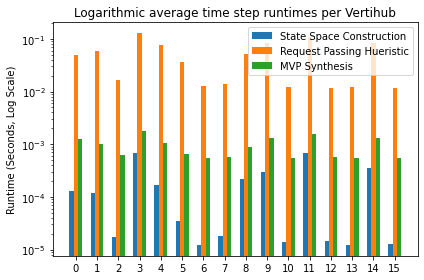

2118


c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


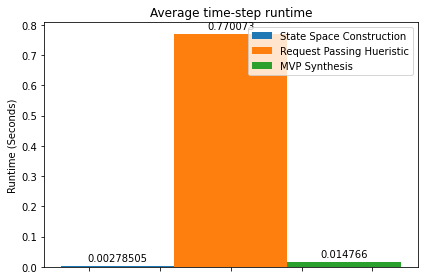

In [59]:
'''
call runtime information functions
'''
generate_per_vertihub_runtime(timing_info_per_tau_per_freq)
generate_avg_per_vertihub_runtime(timing_info_per_tau_per_freq)

In [20]:
'''
table for runtime data

most important data is synthesis per time per timestep. 
Ill just do runtime vs TAU and frequency, one for each trial
'''
# import matplotlib.pyplot as plt

# def generate_runtime_table(timing_info, input_frequencies, trial_num, iteration):
#     row_headers = [''+str(freq) for freq in input_frequencies]
#     column_headers = [''+str(tau) for tau in range(TAU_MAX)]
#     cell_text = []
#     for freq in FREQUENCY_MULTIPLIERS:
#         cell_text.append(timing_info[freq])
#         print(cell_text)
# #         cell_text.append([0 for i in range(TAU_MAX)])
#     the_table = plt.table(cellText=cell_text, rowLabels=row_headers, colLabels=column_headers, loc='center')
#     the_table.scale(1, 1.5)
#     the_table.set_fontsize(25)
    
#     ax = plt.gca()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.box(on=None)
# #     plt.show()
# #     fig = plt.gcf()
#     if USE_PURDUE_DATA:
#         plt.savefig('data/Realtime/OpsLimits/runtime_vs_TAU_and_freq_trial_' + str(trial_num) + '_iteration_' + str(iteration) + '.png',bbox_inches='tight',dpi=216)    
#     else:
#         plt.savefig('data/Realtime/runtime_vs_TAU_and_freq_trial_' + str(trial_num) + '_iteration_' + str(iteration) + '.png',bbox_inches='tight',dpi=216)    
    
#     return plt

# def get_data_per_trial(full_timing_info, full_input_frequencies, trial_index):
#     stub_timing_info = {freq : [0 for i in range(TAU_MAX)] for freq in FREQUENCY_MULTIPLIERS}
#     for freq in full_timing_info:        
#         for TAU in range(len(full_timing_info[freq][trial_index])):
#             timings_without_zeros = [t for t in full_timing_info[freq][trial_index][TAU] if t != 0]
#             stub_timing_info[freq][TAU] += sum(timings_without_zeros)/len(timings_without_zeros)
#     stub_input_frequencies = {freq: 0 for freq in FREQUENCY_MULTIPLIERS}
#     for freq in full_input_frequencies:
#         stub_input_frequencies[freq] = full_input_frequencies[freq][trial_index]
#     return stub_timing_info, stub_input_frequencies
    
    

In [21]:
# average_timing_info = {freq : [0 for i in range(TAU_MAX)] for freq in FREQUENCY_MULTIPLIERS}
# for trial in range(0, NUM_TRIALS):
#     timing_info, input_freq = get_data_per_trial(timing_info_per_tau_per_freq, actual_frequencies_per_freq, trial)
# #     print(timing_info)
#     for key in timing_info:
#         for index,num in enumerate(timing_info[key]):
#             timing_info[key][index] = round(num,3)
#     generate_runtime_table(timing_info, input_freq, trial, 2)
# #     for key in timing_info:
# #         for index,num in enumerate(timing_info[key]):
# #             average_timing_info[key][index] += num
            
# for key in timing_info:
#     for index,num in enumerate(timing_info[key]):
#         average_timing_info[key][index] = round(num,3)
# fig = generate_runtime_table(average_timing_info, input_freq, trial)
    



IndexError: list index out of range

In [22]:
'''
data buffer for mvp output
'''
completed_states = completed_states_per_tau_per_freq[1][0]
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
# wrong_towers_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
wrong_tower_per_time_step = [0 for i in range(len(completed_states[0][0]))]
number_requests_per_TAU = [0 for i in range(len(completed_states[0]))]
# print(completed_states[0][0])
# print(completed_states_per_tau_per_freq[1][0][0][0][0]) freq, something, tau, tower, state
states_per_tau = [0 for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states): # tau
    for index, com in enumerate(completed): # vertihub
        for time_step, state in enumerate(com):
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1
            states_per_tau[tau] += 1
            for req in state.request_vector:
                if req == 'wrong_tower':
                     wrong_tower_per_time_step[time_step] += 1
#                      wrong_towers_per_tau[tau][time_step] += 1
                    
# print(completed_states[0][0])
# sums = [sum(i) for i in wrong_towers_per_tau]
# print(sums)          
other_sums = [sum(i)/states_per_tau[tau] for tau, i in enumerate(percent_valid_per_tau)]
print(other_sums)

    

# for tower_cost in percent_valid_per_tau:
#     print(tower_cost)
# mvp_output_per_tower_per_tau_copy = copy.deepcopy(mvp_output_per_tower_per_tau)
# for tau in mvp_output_per_tower_per_tau_copy:
#     for output in tau:
#         gm.print_formatted_cost(output[0],format_override=True)
# for timings in timing_info:
#     print(sum(timings))
#     print (timings)
    

IndexError: list index out of range

In [23]:

'''
More data processing
plot cost per tau over time
'''
# sum up the negative costs for the tower (get total expiration value)
cost_per_tau_over_time = [[] for i in range(TAU_MAX)]
for index,tau in enumerate(completed_states):
    sum_cost = 0
    for time_step in range(len(completed_states[0][0])):
        for tower in tau:
            for expiration in tower[time_step].time_vector:
                if expiration < 0:
                    sum_cost -= expiration 
#                     sum_cost +=1
        cost_per_tau_over_time[index].append(sum_cost)
cost_per_tau_over_time = cost_per_tau_over_time
# print(cost_per_tau_over_time)
x = [i for i in range(len(completed_states[0][0]))]
plt.plot(x, cost_per_tau_over_time[0])
# for tau_num, tau in enumerate(cost_per_tau_over_time):
#     plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cumulative Expiration Error')
save_plot(plt, 'cummulative_expiration_error_over_time')
plt.show()

NameError: name 'completed_states' is not defined

In [24]:

'''
first plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
'''
x = [i+1 for i in range(len(completed_states[0][0]))]
cummulative_wrong_tower_error = [0 for i in range(len(wrong_tower_per_time_step))]
for idx, i in enumerate(wrong_tower_per_time_step):
    if idx == 0:
        continue
    cummulative_wrong_tower_error[idx] = i + cummulative_wrong_tower_error[idx-1]
print(wrong_tower_per_time_step)
plt.plot(x, cummulative_wrong_tower_error)
# for tau_num, tau in enumerate(cost_per_tau_over_time):
#     plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cumulative Swap Error')
save_plot(plt, 'cummulative_swap_error_over_time')

plt.show()


NameError: name 'completed_states' is not defined

In [25]:
'''
second plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
also include a line for the traffic over time
'''
cum_input_len_over_time = [0 for i in x]
for time_step in range(len(_input)):
    if time_step > 0:
        cum_input_len_over_time[time_step] = cum_input_len_over_time[time_step-1]  
    for key in _input[time_step][0].keys():
        cum_input_len_over_time[time_step] += len(_input[time_step][0][key])
print (cum_input_len_over_time)
for i in range(len(_input), len(x)):
    cum_input_len_over_time[i] = cum_input_len_over_time[i-1]

fig,ax1 = plt.subplots()
# print (cost_per_tau_over_time[4])
for tau_num, tau in enumerate(cost_per_tau_over_time):
    ax1.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cumulative Error')
input_len_over_time = [0 for i in x]
for time_step in range(len(_input)):
    for key in _input[time_step][0].keys():
        input_len_over_time[time_step] += len(_input[time_step][0][key])
ax2 = ax1.twinx()
ax2.bar(x, input_len_over_time, color='r', alpha=0.1)
# ax2.plot(x, cum_input_len_over_time, 'r.')
ax2.set_ylabel('Additional Requests')
ax2.tick_params('y',colors='r')
    # plt.savefig('data/Realtime/OpsLimits/cumulative_error_over_time_with_requests' + str(random.randrange(0,100000)) + '.png',dpi=216)    
save_plot(plt, 'cumulative_error_over_time_with_requests')

    # plt.savefig('data/Realtime/cumulative_error_over_time_with_requests' + str(random.randrange(0,100000)) + '.png',dpi=216)

NameError: name 'x' is not defined

In [26]:
'''
second plot:
traffic over time
'''
input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    for key in input[time_step][0].keys():
        input_len_over_time[time_step] += len(input[time_step][0][key])
plt.bar(x, input_len_over_time)


NameError: name 'x' is not defined

In [27]:
'''
timings data
'''
for timings in timing_info:
#     print(timings)
    print(sum(timings))

NameError: name 'timing_info' is not defined